# Learn to design robust single-qubit gates using computational graphs
**Generate and test robust controls in Boulder Opal**

In this tutorial you will find optimal pulses to implement a quantum gate for a single qubit, and test them against a scan of noise amplitude values.

You will achieve that by creating a graph representing your control optimization problem, and using the highly flexible optimization engine in Boulder Opal to obtain high fidelity pulses robust to noise processes.
You will then test these pulses by calculating the infidelity of your gate for a range of values of the noise amplitude with another graph.
If you want to learn more about graphs and their use in Boulder Opal, we recommend that you read our [related topic](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal).

## Design robust controls for a single qubit

Your first task will be to obtain robust controls which implement a Y gate in a noisy single-qubit system.
In particular, the system is described by a Hamiltonian of the form
$$
H(t) = \alpha(t) \sigma_{z} + \frac{1}{2}\left(\gamma(t)\sigma_{-} + \gamma^*(t)\sigma_{+}\right) + \delta \sigma_{z} + \beta(t) \sigma_{z} , 
$$
where
$\sigma_{z}$ is the Pauli Z operator,
$\sigma_{\pm}$ are the qubit ladder operators,
$\alpha(t)$ and $\gamma(t)$ are, respectively, real and complex time-dependent controls that you can manipulate, 
$\delta$ is the qubit detuning, and
$\beta(t)$ is a dephasing noise process.
Note that this model corresponds to a qubit coupled to a classical bath.
The dephasing amplitude $\beta(t)$ is slowly varying so that you can assume that it is constant at each different realization.

To generate the robust controls, you will create a computational graph that solves the Schrödinger equation for the system's Hamiltonian with optimizable controls $\alpha(t)$ and $\gamma(t)$ and calculates the infidelity with respect to your target gate.
By using the optimization engine in Boulder Opal, you will then find the controls that minimize that infidelity.

### 1. Import libraries

Before doing any calculation with Boulder Opal you always need to import the necessary libraries

In this case, import the `numpy`, `matplotlib.pyplot`, `qctrlvisualizer`, and `boulderopal` packages.
To learn more about installing Boulder Opal, see the [Get started](https://docs.q-ctrl.com/boulder-opal/get-started) guide.

In [1]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer
import boulderopal as bo

# Apply Q-CTRL style to plots created in pyplot.
plt.style.use(qctrlvisualizer.get_qctrl_style())

### 2. Create the graph defining the optimization

The relationships between inputs and outputs of a quantum system calculation in Boulder Opal are represented by a graph.

#### Create the graph object

Start by creating the graph object that will define the calculation.
You can do this by instantiating a `boulderopal.Graph` class.

In [2]:
graph = bo.Graph()

#### Create optimizable signals for the Hamiltonian terms

Control optimizations in Boulder Opal start by defining the time-dependent coefficients for the different Hamiltonian terms you want to optimize over, in this case, $\alpha(t)$ and $\gamma(t)$.

Start by creating an optimizable PWC in the graph representing $\alpha(t)$, using the `graph.real_optimizable_pwc_signal` operation.
Assign a name to this node with the `name` parameter so that you can retrieve its value after the optimization.

In [3]:
# Pulse parameters.
segment_count = 50
duration = 10e-6  # s

# Maximum value for |α(t)|.
alpha_max = 2 * np.pi * 0.25e6  # rad/s

# Real PWC signal representing α(t).
alpha = graph.real_optimizable_pwc_signal(
    segment_count=segment_count,
    duration=duration,
    minimum=-alpha_max,
    maximum=alpha_max,
    name="$\\alpha$",
)

Following the same steps as you have just done for $\alpha(t)$, create an optimizable PWC in the graph representing $\gamma(t)$, using `graph.complex_optimizable_pwc_signal`, and assign a name to it.

In [4]:
# Maximum value for |γ(t)|.
gamma_max = 2 * np.pi * 0.5e6  # rad/s

# Complex PWC signal representing γ(t)
gamma = graph.complex_optimizable_pwc_signal(
    segment_count=segment_count, duration=duration, maximum=gamma_max, name="$\\gamma$"
)

#### Construct the Hamiltonian

You have just defined the signals you want to find optimal values for.
The next step is to construct the system's Hamiltonian (so you can define the target of the optimization: the infidelity of the gate realized by these pulses).

You can construct it by multiplying each signal (or constant) by its corresponding operator and adding the different terms.
You can use `graph.hermitian_part` to obtain the Hermitian part of $\gamma(t) \sigma_-$.

In [5]:
# Detuning δ.
delta = 2 * np.pi * 0.25e6  # rad/s

# Total Hamiltonian.
hamiltonian = (
    alpha * graph.pauli_matrix("Z")
    + graph.hermitian_part(gamma * graph.pauli_matrix("M"))
    + delta * graph.pauli_matrix("Z")
)

#### Define the target operation you want to achieve

Now the graph contains a representation of your system's Hamiltonian with optimizable controls. 
Next, use the `graph.target` operation to define the target operation that the Hamiltonian is meant to realize.


In [6]:
# Target operation node.
target = graph.target(operator=graph.pauli_matrix("Y"))

#### Define the noise processes in the system

With the system Hamiltonian and the target gate, you now have all the ingredients needed to calculate the gate infidelity.
However, as you want your controls to be robust against dephasing, you need to create operators representing that noise process.

In this case, as the noise amplitude $\beta(t)$ is slowly varying, you can consider it to be constant but with a different amplitude at each experiment realization.
Thus, give it an amplitude representing the order of magnitude of the expected dephasing values.

In [7]:
# Dephasing noise amplitude.
beta = 2 * np.pi * 20e3  # rad/s

# (Constant) dephasing noise term.
dephasing = beta * graph.pauli_matrix("Z")

#### Create the cost node for a  gate infidelity

You can now create a node with the robust infidelity of the gate realized by your pulses with the `graph.infidelity_pwc` operation with the PWC `hamiltonian` and your `target` operation.
This convenient node takes care of solving the Schrödinger equation with your time-dependent PWC Hamiltonian, and calculating the infidelity with respect to the target operation.

Pass it also the `dephasing` noise operator so that the infidelity includes its associated filter function values, making it robust against this type of noise.
Assign a name to it so you can tell the optimizer this is the (cost) node whose value should be minimized.

In [8]:
# Robust infidelity.
robust_infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian,
    noise_operators=[dephasing],
    target=target,
    name="robust_infidelity",
)

Now you have defined a full graph describing the relationship between the optimizable signals and the robust gate infidelity.

### 3. Optimize the graph

You can optimize the graph using the `boulderopal.run_optimization` function.
It will attempt to minimize the node whose `cost_node_name` you provide (in this case, the robust infidelity).
You need to also provide it with the `output_node_names` of the nodes that you want to retrieve, in this case the PWC signals $\alpha(t)$ and $\gamma(t)$.

In [9]:
optimization_result = bo.run_optimization(
    graph=graph,
    cost_node_name="robust_infidelity",
    output_node_names=["$\\alpha$", "$\\gamma$"],
)

Your task (action_id="1828678") is queued.
Your task (action_id="1828678") has started.
Your task (action_id="1828678") has completed.


### 4. Analyze the calculation outputs

#### Extract the optimized cost value

After the graph optimization has completed, all of the output data is stored in the dictionary returned by `boulderopal.run_optimization`.
You can retrieve the final value of the optimized cost (the infidelity plus filter function values) from `optimization_result["cost"]`.

In [10]:
print(f"Optimized robust cost: {optimization_result['cost']:.3e}")

Optimized robust cost: 6.369e-12


You can see that the obtained cost is very small, meaning that the pulse will implement your target gate with a very high fidelity, while still being robust to dephasing.
You will check this shortly.

#### Extract and plot the robust pulses

The values of the nodes that you have requested when optimizing the graph are stored in the dictionary `optimization_result["output"]`.
You can use the `plot_controls` function in the [Q-CTRL Visualizer](https://docs.q-ctrl.com/references/qctrl-visualizer/) to visualize the optimized pulses.

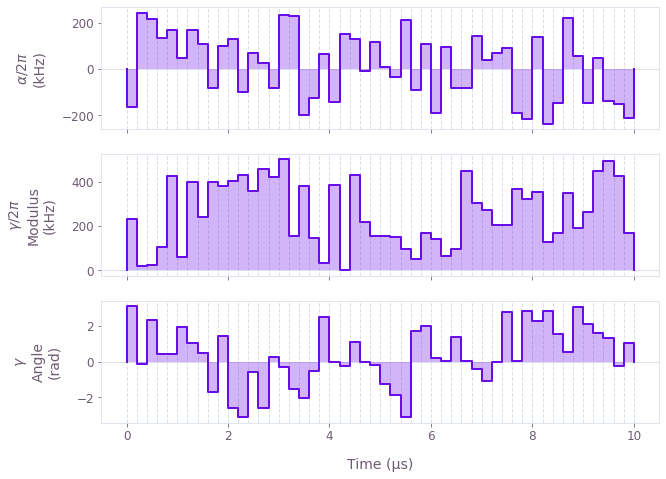

In [11]:
qctrlvisualizer.plot_controls(optimization_result["output"])

Although the structure of these controls is not obvious at first glance, they work in such a way that they end up implementing a Y gate, and canceling the effects of the dephasing in the system.
Their jagged look is due to the PWC representation you have used, but Boulder Opal can also produce [continuous pulses by adding smoothing or band limits to them](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-add-smoothing-and-band-limits-to-optimized-controls).

## Test the robust controls

Your next task will be to study how the controls you have just obtained behave for a range of dephasing values.
From the low optimization cost, you would expect that the pulses should yield low infidelities for a range of dephasing values.

You will now set up another graph to calculate the gate infidelity of the robust controls for different values of the dephasing.
Instead of looping over the different values of the dephasing we are interested in, you will create a batch of dephasing terms, so that the graph calculation only has to be run once.
You can learn more about batching from our [Batching and broadcasting in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/batching-and-broadcasting-in-boulder-opal) topic.

### 1. Create the graph defining the scan

#### Create the graph object

Start by creating a new graph to define the infidelity scan.
This graph will be very similar to the optimization one you defined above, but using the optimized values for the pulses instead of optimizable ones.

In [12]:
# Create a new Boulder Opal graph.
graph = bo.Graph()

#### Create PWC signals with the robust controls

Similarly to how you created the optimizable PWC signals in the optimization graph, define PWC signals for $\alpha(t)$ and $\gamma(t)$, but this time use the values resulting from the optimization.

For example, the robust PWC controls for $\alpha(t)$ are in `optimization_result["output"]["$\\alpha$"]`, as a dictionary with `"values"` and `"durations"`.
You can unpack this dictionary when calling `graph.pwc` to create a PWC signal in the graph representing $\alpha(t)$.

In [13]:
# Create PWCs for α(t) and γ(t) from the robust controls in the optimization.
alpha = graph.pwc(**optimization_result["output"]["$\\alpha$"])
gamma = graph.pwc(**optimization_result["output"]["$\\gamma$"])

#### Create a batch of dephasing operators

As you want to analyze what happens for a range of values of the dephasing amplitude $\beta$, create a batch of dephasing operators terms.
Create a 1D array with the values of $\beta$ that you would like to scan over.
Pass those to `graph.constant_pwc`, along with the pulse `duration` and a `batch_dimension_count` of 1 (as the scan you're performing is over a single axis).

In [14]:
# Values of β to scan over.
beta_values = np.linspace(-beta, beta, 100)

# 1D batch of constant PWC
dephasing_amplitude = graph.constant_pwc(
    beta_values, duration=duration, batch_dimension_count=1
)

This creates a batch of constant (scalar) PWCs, each element in it representing a different value of $\beta$.
Using this to build your Hamiltonian will create a batch of Hamiltonians for each of the values of $\beta$.

#### Construct the Hamiltonian

Construct the full Hamiltonian of the system in the same way you did in the optimization graph, but this time also include the dephasing term.

In [15]:
# Total Hamiltonian.
hamiltonian = (
    alpha * graph.pauli_matrix("Z")
    + graph.hermitian_part(gamma * graph.pauli_matrix("M"))
    + delta * graph.pauli_matrix("Z")
    + dephasing_amplitude * graph.pauli_matrix("Z")
)

#### Calculate the gate infidelity

Define the infidelity of the Hamiltonian with `graph.infidelity_pwc` and a target defined with `graph.target`.
Note that this time you don't need to pass `noise_operators` as you are interested in the actual operational infidelity (without the filter function values).
Assign a node to it so you can retrieve it when the graph is executed.

In [16]:
# Target operation node.
target = graph.target(operator=graph.pauli_matrix("Y"))

# Quasi-static scan infidelity.
infidelity = graph.infidelity_pwc(
    hamiltonian=hamiltonian, target=target, name="infidelity"
)

As the `hamiltonian` is a batch of Hamiltonians for different values of $\beta$, this infidelity node will contain the infidelity for each value of $\beta$ you selected.

### 2. Execute the graph

You now have a graph representing the dephasing scan calculation.
You can execute it with `boulderopal.execute_graph` to evaluate the graph and get the outputs.
Pass to it the `output_node_names` of the nodes you want to retrieve, the `"infidelity"` for all dephasing values.

In [17]:
quasi_static_scan_result = bo.execute_graph(graph=graph, output_node_names="infidelity")

Your task (action_id="1828686") is queued.
Your task (action_id="1828686") has started.
Your task (action_id="1828686") has completed.


### 3. Extract the calculation outputs

Similarly to the optimization calculation, all the output data is stored in the dictionary returned by `boulderopal.execute_graph`.
In particular, `quasi_static_scan_result["output"]` is a dictionary containing the values of the nodes you have requested when calculating the graph.
Extract the array containing the infidelities.

In [18]:
# Array with the scanned infidelities.
infidelities = quasi_static_scan_result["output"]["infidelity"]["value"]

### 4. Plot the infidelity scan

Plot the infidelities as a function of $\beta$.

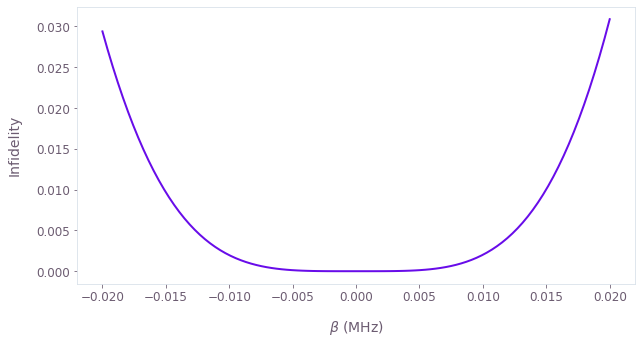

In [19]:
# Create plot with the infidelity scan.
plt.plot(beta_values / 1e6 / 2 / np.pi, infidelities)
plt.xlabel(r"$\beta$ (MHz)")
plt.ylabel("Infidelity")
plt.show()

You can see that the infidelity is very low for a wide range of $\beta$ values around zero, and particularly flat in the central region, showing the robustness of the pulse.

This concludes the tutorial. Congratulations on designing and testing your first robust pulses!

You can now try optimizing controls for different quantum systems or robust to different types of noise by changing the optimization graph you have defined.
Our [user guides](https://docs.q-ctrl.com/boulder-opal/user-guides/) can also help you extend this powerful control optimization tool to other quantum problems.
If you want to generate smooth control pulses, please refer to our [How to add smoothing and band-limits to optimized controls](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-add-smoothing-and-band-limits-to-optimized-controls) user guide.
You might also be interested in reading about [Hamiltonians with nonlinear dependences](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-controls-with-nonlinear-dependences) or [dealing with systems in large Hilbert spaces](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-controls-on-large-sparse-hamiltonians).
You can also read more about [evaluating control susceptibility to quasi-static noise](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-evaluate-control-susceptibility-to-quasi-static-noise).

If you want to learn more about graphs, you can read our [Understanding graphs in Boulder Opal](https://docs.q-ctrl.com/boulder-opal/topics/understanding-graphs-in-boulder-opal) topic.
You can also learn how to use graphs to simulate and visualize quantum dynamics in our [tutorial about simulation](https://docs.q-ctrl.com/boulder-opal/tutorials/simulate-the-dynamics-of-a-single-qubit-using-computational-graphs).